# LSH Density Estimation Performance Assessment on High-Dimensional data

Assessing the performance of the LSH density estimation algorithm

In [18]:
import os, sys
sys.path.append(os.path.join(".."))
from benchmark_synthetic_data import sample_blobs
from lsh_density.lsh_based_kde import run_high_dim_kde, lsh_granularity
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr
import random as rd

#### Generating synthetic multi-cluster high-dimensional data

In this performance assessment, we will work with `n_features = 50`. We will also scale up the amount of data to somewhere within the range of `n_samples = 15000 `to `n_samples = 25000`. This is required to ensure that the LSH density estimation algorithm can effectively capture the underlying structure of the data.

In [3]:
all_samples = []
all_labels = []
for _ in range(15):
    n_samples = rd.randint(10, 2500)
    std = rd.uniform(0.1, 1.0)
    clusters_centers = rd.randint(1, 10)
    samples, labels = sample_blobs(n_samples=n_samples, n_features=50, clusters_centers=clusters_centers, cluster_std=std, random_state=42, verbose=False)
    all_samples += samples.tolist()
    all_labels += labels
    
all_samples = np.array(all_samples)
print()
print("All samples shape:", all_samples.shape)
print("Set of labels:", set(all_labels))


All samples shape: (20847, 50)
Set of labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


---

#### Computing the LSH density estimation

In [29]:
lsh_densities = run_high_dim_kde(dataset=all_samples, hash_bits_per_table=20, number_of_hash_tables=30, random_state=42, verbose=True)

Running LSH-based KDE with 20 hash bits per table and 30 hash tables.
Preparing hash tables and planes...
Hash tables and planes prepared.
Hashing the dataset...
Dataset hashed.
Computing densities for the dataset...
Densities computed.
Computed densities using LSH and SimHash for 20847 samples.


In [36]:
theta, cosine_similarity_threshold = lsh_granularity(n_bits=20, p_target=0.5)
print(f"Effective angular threshold: {theta:.4f} rad")
print(f"Equivalent cosine similarity: {cosine_similarity_threshold:.4f}")

Effective angular threshold: 0.1070 rad
Equivalent cosine similarity: 0.9943


---

#### Computing the ground truth densities

In [37]:
cosine_similarity_matrix = cosine_similarity(all_samples)

# Calculate the exact density based on cosine similarity threshold
neighbours_count = (cosine_similarity_matrix >= cosine_similarity_threshold).sum(axis=1) - 1
ground_truth_densities = neighbours_count / len(neighbours_count)

----

##### Spearman Correlation Coefficient

The Spearman correlation coefficient will be used to assess the performance of the LSH density estimation algorithm. The Spearman correlation coefficient is a non-parametric measure of rank correlation, which assesses how well the relationship between two variables can be described using a monotonic function. In this case, it will be used to compare the estimated density against the ground truth density.

The result will be a value between -1 and 1, where 1 indicates a perfect positive correlation, -1 indicates a perfect negative correlation, and 0 indicates no correlation.
Here, we expect a value close to 1, indicating that the estimated density is closely related to the ground truth density.

In [38]:
rho, _ = spearmanr(ground_truth_densities, lsh_densities)
mae = np.mean(np.abs(ground_truth_densities - lsh_densities))

print("Spearman correlation:", rho)
print("Mean absolute error:", mae)

Spearman correlation: 0.8797075917630774
Mean absolute error: 0.03898748554205025


The value of the Spearman correlation coefficient is of about 0.88, indicating again a strong positive correlation between the estimated density and the ground truth density. This suggests that the LSH density estimation algorithm is performing well in estimating the density of the dataset.
The Spearman correlation coefficient seems to be slightly lower than the one obtained in the previous performance assessment, which is expected given the increased complexity of the dataset.

----

##### Visualizing the Estimated Density Against the Ground Truth Density

We can also visualize the estimated density against the ground truth density to get a better understanding of the performance of the LSH density estimation algorithm. We will plot the estimated density and the ground truth density on the same graph to visually assess the performance of the algorithm.

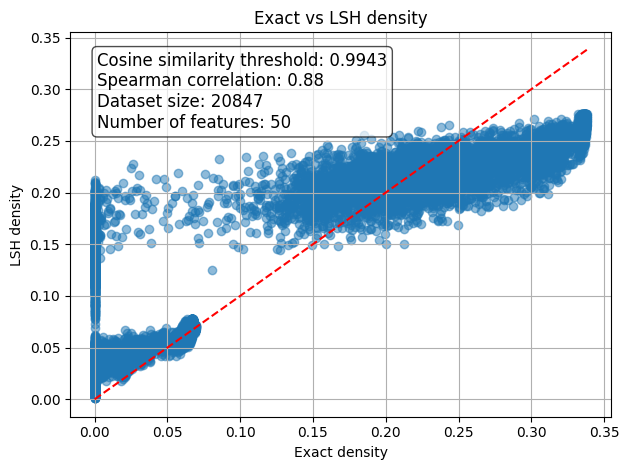

In [39]:
plt.scatter(ground_truth_densities, lsh_densities, alpha=0.5)
plt.text(
    0.05, 0.95,
    f"Cosine similarity threshold: {cosine_similarity_threshold:.4f}\n\
Spearman correlation: {rho:.2f}\nDataset size: {len(all_samples)}\nNumber of features: {all_samples.shape[1]}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
plt.xlabel("Exact density")
plt.ylabel("LSH density")
plt.title("Exact vs LSH density")
plt.plot([ground_truth_densities.min(), ground_truth_densities.max()],
         [ground_truth_densities.min(), ground_truth_densities.max()],
         color='r', linestyle='--')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join("..", "results", "plots", "exact_vs_lsh_density_50d.png"))
plt.show()

The plot shows the estimated density against the ground truth density.
There are three main observations:

1. There are two main clusters of points, which are located near to the diagonal line. This indicates that the estimated density is closely related to the ground truth density, which is a good sign for the performance of the LSH density estimation algorithm. This is also confirmed by a high Spearman correlation coefficient value of 0.88.

2. In lower density regions, the estimated density tends to "overestimate" the ground truth density. In higher density regions, the estimated density tends to "underestimate" the ground truth density.

3. The exact density values in the range of 0.07 to 0.12 are not well captured by the LSH density estimation algorithm. This is not surprising, given that the exact density values are very sparse in this range. There are very few values, and even if the LSH density estimation algorithm had not overestimated these densities, there would still be very few points in this range. 

Therefore, to assess the performance of the LSH density estimation algorithm, we can plot a linear regression line to see how well the estimated density fits the ground truth density. Then, we should be able to compare the slopes and intercepts of the linear regression line with the expected values of 1 and 0, respectively. This will give us a better understanding of the performance of the LSH density estimation algorithm.

Linear regression slope: 0.6886, intercept: 0.0420


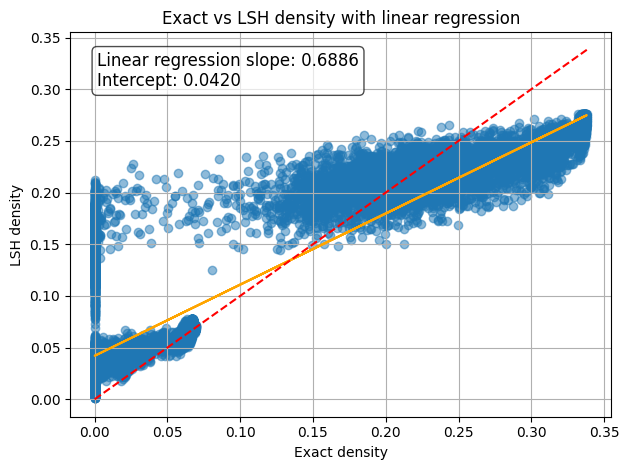

In [40]:
X = ground_truth_densities.reshape(-1, 1)
y = np.array(lsh_densities).reshape(-1, 1)
reg = LinearRegression().fit(X, y)
slope = reg.coef_[0][0]
intercept = reg.intercept_[0]
print(f"Linear regression slope: {slope:.4f}, intercept: {intercept:.4f}")
plt.scatter(ground_truth_densities, lsh_densities, alpha=0.5)
plt.plot(X, reg.predict(X), color='orange', label='Linear regression')
plt.text(
    0.05, 0.95,
    f"Linear regression slope: {slope:.4f}\n\
Intercept: {intercept:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
plt.xlabel("Exact density")
plt.ylabel("LSH density")
plt.title("Exact vs LSH density with linear regression")
plt.plot([ground_truth_densities.min(), ground_truth_densities.max()],
         [ground_truth_densities.min(), ground_truth_densities.max()],
         color='r', linestyle='--')
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join("..", "results", "plots", "exact_vs_lsh_density_with_linear_regression_50d.png"))
plt.show()

---

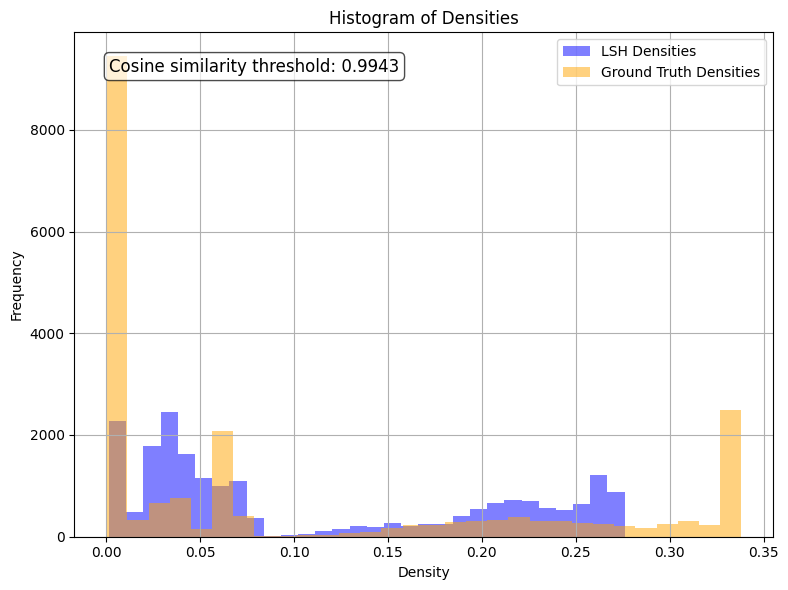

In [41]:
plt.figure(figsize=(8, 6))
plt.hist(lsh_densities, bins=30, alpha=0.5, label='LSH Densities', color='blue')
plt.hist(ground_truth_densities, bins=30, alpha=0.5, label='Ground Truth Densities', color='orange')
plt.text(
    0.05, 0.95,
    f"Cosine similarity threshold: {cosine_similarity_threshold:.4f}",
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.7)
)
plt.xlabel('Density')
plt.ylabel('Frequency')
plt.title('Histogram of Densities')
plt.legend()
plt.grid()
plt.tight_layout()
plt.savefig(os.path.join("..", "results", "plots", "density_histogram.png"))
plt.show()